In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import pandas as pd
import numpy as np
import tensorflow as tf

logging.basicConfig(level=logging.DEBUG)

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
# Configuración de logging para visualizar el proceso
logging.basicConfig(level=logging.DEBUG)
#logger = logging.getLogger("ReturnPredictor")

## 1 Inicialización y carga de datos

In [124]:
dirname = '/content/drive/MyDrive/cursos PUCP/Deep learning finanzas/data_clases'
filename = os.path.join(dirname, "NVDA.csv")
df = pd.read_csv(filename)

In [125]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376255,271468800
1,1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415672,51048000
2,1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383422,34320000
3,1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382227,24436800
4,1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381033,22752000


In [126]:
df.shape

(6310, 7)

## 2 Definición de parámetros a utilizar en la configuración y entrenamiento del modelo

In [127]:
nUnit = 10  # Número de unidades en la capa LSTM del modelo
nTimestep = 10  # Número de pasos de tiempo en cada secuencia de entrada ######
batchSize = 10  # Tamaño del lote utilizado durante el entrenamiento del modelo
nEpoch = 100  # Número de épocas de entrenamiento del modelo, se mejora la prediccion si se aumenta
trainTestSplit = 0.8  # Proporción del conjunto de datos para entrenamiento vs prueba
daysInMonth = 21  # Número de días en un mes

# 3 Definición de nombres de columnas utilizados en el conjunto de datos

In [128]:
dateCol = "Date"  # Fechas
priceCol = "Adj Close"  # Precios ajustados por splits, dividendos
volCol = "Volume"  # Volumen de operaciones

volatilityCol = "VolatRatio"  # Relación de volatilidad
volumeCol = "VolumeRatio"  # Relación de volumen
momentumCol = "Momentum"  # Columna para el momentum

returnCol = "Last1MoReturn"  # Columna para el retorno del último mes
returnCol_2 ="Last1week" # Columna para el retorno de la última semana
resultCol = "Fwd1MoReturn"  # Columna para el retorno futuro del próximo mes

# Media móvil de 50 periodos
media_movil_50 = "ema50"

# Media móvil de 100 periodos
media_movil_100 = "ema100"


# 4 Ingeniería de características

In [129]:
# 1 Date: onvertimos la columna de fechas al tipo datetime
df[dateCol] = pd.to_datetime(df[dateCol])

# 2 Last1MoReturn: Calculamos los retornos diarios a partir de los precios
returns = np.zeros(df.shape[0], dtype=np.float32)
nrow = df.shape[0]
# Calculamos los retornos diarios como el cambio porcentual en el precio de cierre ajustado respecto al día anterior
returns[daysInMonth+1:] = np.divide(df.loc[daysInMonth:nrow-2, priceCol].values, df.loc[0:nrow-daysInMonth-2, priceCol].values) - 1
df[returnCol] = returns

# 2 Momentum: Calculamos el momentum a partir de los retornos diarios
momentum = np.zeros(df.shape[0], dtype=np.float32)
# Calculamos los retornos de los últimos 3 meses
returns3Mo = np.divide(df.loc[3*daysInMonth:nrow-2, priceCol].values, df.loc[0:nrow-3*daysInMonth-2, priceCol].values) - 1
# Calculamos el momentum como la proporción entre los retornos diarios recientes y los retornos de los últimos 3 meses
num = returns[3*daysInMonth+1:]
momentum[3*daysInMonth+1:] = np.divide(num, np.abs(num) + np.abs(returns3Mo))
df[momentumCol] = momentum

# 3 VolatRatio: Normalizamos la volatilidad media anual
df[volatilityCol] = 0
volatility = np.zeros(nrow, dtype=np.float32)
rtns = returns[daysInMonth+1:2*daysInMonth+1]
sumval = np.sum(rtns)
sumsq = np.sum(rtns * rtns)
# Calculamos la volatilidad como la raíz cuadrada de la varianza móvil de 21 días de los retornos diarios
for i in range(2*daysInMonth+1, nrow):
    mean = sumval / daysInMonth
    volatility[i] = np.sqrt(sumsq / daysInMonth - mean*mean)
    sumval += returns[i] - returns[i-daysInMonth]
    sumsq += returns[i] * returns[i] - returns[i-daysInMonth] * returns[i-daysInMonth]
oneyr = 12 * daysInMonth
# Normalizamos la volatilidad dividiéndola por la media de la volatilidad de los últimos 12 meses
df[volatilityCol] = 0.0
for i in range(oneyr+2*daysInMonth+1, nrow):
    df.loc[i, volatilityCol] = volatility[i] / np.mean(volatility[i-oneyr:i])

# 4 VolumeRatio: Normalizamos el volumen
df[volumeCol] = 0
volume = df.loc[:, volCol].values
# Calculamos la relación de volumen como el volumen actual dividido por la media del volumen de los últimos 21 días
for i in range(daysInMonth, nrow-1):
    df.loc[i+1, volumeCol] = volume[i] / np.mean(volume[i-daysInMonth:i])

# 5 Fwd1MoReturn: Calculamos el resultado (retorno futuro)
df[resultCol] = 0.0
# Asignamos los retornos futuros como el retorno diario desplazado 21 días hacia adelante
df.loc[0:nrow-daysInMonth-1, resultCol] = df.loc[daysInMonth:, returnCol].values

# 6 generacion de medias moviles de 50 y 100 peridodos
df[media_movil_50] = df[priceCol].rolling(50).mean()
df[media_movil_100] = df[priceCol].rolling(100).mean()

In [130]:
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Last1MoReturn,Momentum,VolatRatio,VolumeRatio,Fwd1MoReturn,ema50,ema100
0,1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376255,271468800,0.0,0.0,0.0,0.0,0.00000,NaN,NaN
1,1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415672,51048000,0.0,0.0,0.0,0.0,0.11746,NaN,NaN


In [131]:
df.tail(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Last1MoReturn,Momentum,VolatRatio,VolumeRatio,Fwd1MoReturn,ema50,ema100
6308,2024-02-16,741.000000,744.020020,725.010010,726.130005,726.130005,49391800,0.296237,0.389995,0.950737,0.866798,0.0,569.234799,511.392171
6309,2024-02-20,719.469971,719.559998,677.340027,694.520020,694.520020,70171600,0.271525,0.358710,0.883310,1.024518,0.0,574.024600,514.146640


In [132]:
import pandas as pd
# Redondeamos los valores del resumen estadístico a dos decimales
rounded_df = df.describe().round(1)
# Convertimos el resumen estadístico redondeado en un DataFrame
rounded_df = pd.DataFrame(rounded_df)
# Imprimimos el DataFrame
rounded_df.T

,count,mean,std,min,25%,50%,75%,max
Open,6310.0,45.3,98.0,0.3,2.7,4.5,39.0,741.0
High,6310.0,46.1,99.6,0.4,2.8,4.6,39.6,746.1
Low,6310.0,44.4,96.2,0.3,2.7,4.4,38.2,725.0
Close,6310.0,45.3,98.1,0.3,2.7,4.5,39.0,739.0
Adj Close,6310.0,45.1,98.1,0.3,2.5,4.2,38.8,739.0
Volume,6310.0,60890341.8,43504689.9,1968000.0,34674525.0,51027600.0,73950300.0,923085600.0
Last1MoReturn,6310.0,0.0,0.2,-0.6,-0.1,0.0,0.1,2.0
Momentum,6310.0,0.1,0.4,-1.0,-0.3,0.1,0.4,1.0
VolatRatio,6310.0,1.0,0.5,0.0,0.6,0.9,1.2,3.9
VolumeRatio,6310.0,1.0,0.6,0.0,0.7,0.9,1.2,11.5


# 5 Preparación de los datos de entrenamiento y prueba

In [133]:
# Calculamos el número de muestras para el conjunto de entrenamiento
ntrain = int(trainTestSplit * df.shape[0])

# Seleccionamos las muestras de entrenamiento y prueba, y las reindexamos
trainDf = df.loc[14*daysInMonth+1:ntrain, :].reset_index(drop=True)
testDf = df.loc[ntrain:, :].reset_index(drop=True)

In [134]:
print("Tamaño de trainDf:", trainDf.shape)
print("Tamaño de testDf:", testDf.shape)

Tamaño de trainDf: (4754, 14)
Tamaño de testDf: (1262, 14)


In [135]:
trainDf.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Last1MoReturn,Momentum,VolatRatio,VolumeRatio,Fwd1MoReturn,ema50,ema100
0,2000-03-23,1.972656,2.135417,1.96875,2.026042,1.85858,30940800,0.458969,0.268796,3.278762,0.291628,-0.156311,1.21301,0.967602


In [136]:
print("Primeras 4 filas:")
testDf.head(4)

Primeras 4 filas:


,Date,Open,High,Low,Close,Adj Close,Volume,Last1MoReturn,Momentum,VolatRatio,VolumeRatio,Fwd1MoReturn,ema50,ema100
0,2019-02-14,38.209999,38.917500,37.775002,38.632500,38.332420,82726400,0.016219,0.059596,1.143915,0.787454,0.111885,36.077029,45.146843
1,2019-02-15,40.737499,40.967499,39.105000,39.334999,39.029469,151674800,0.031094,0.144630,1.141191,1.084469,0.094442,36.014022,44.884281
2,2019-02-19,39.227501,39.972500,39.035000,39.160000,38.855816,55189200,0.057108,0.213973,1.127356,1.962562,0.117904,36.011690,44.614408
3,2019-02-20,39.455002,40.314999,39.342499,39.637501,39.329620,54098800,0.032428,0.136669,1.111238,0.670846,0.114529,36.012980,44.342557


In [137]:
print("\nÚltimas 4 filas:")
testDf.tail(4)


Últimas 4 filas:


,Date,Open,High,Low,Close,Adj Close,Volume,Last1MoReturn,Momentum,VolatRatio,VolumeRatio,Fwd1MoReturn,ema50,ema100
1258,2024-02-14,732.020020,742.359985,719.380005,739.000000,739.000000,50491700,0.318370,0.392684,1.036716,1.281709,0.0,558.594999,505.247534
1259,2024-02-15,738.690002,739.750000,724.000000,726.580017,726.580017,42012200,0.310702,0.373985,0.989608,1.047443,0.0,564.025399,508.352700
1260,2024-02-16,741.000000,744.020020,725.010010,726.130005,726.130005,49391800,0.296237,0.389995,0.950737,0.866798,0.0,569.234799,511.392171
1261,2024-02-20,719.469971,719.559998,677.340027,694.520020,694.520020,70171600,0.271525,0.358710,0.883310,1.024518,0.0,574.024600,514.146640


In [138]:
nfeat = len([returnCol, momentumCol, volatilityCol, volumeCol, media_movil_50, media_movil_100])
nfeat

6

- variables de entrada: data: contiene  secuencias temporales de los datos seleccionados del DataFrame df, que incluyen las columnas returnCol, momentumCol, volatilityCol y volumeCol.

- variable de salida: results: contiene las secuencias temporales de los resultados esperados que la red neuronal recurrente debe predecir. Estos resultados se toman de la columna resultCol del DataFrame df.

In [139]:
# Definimos una función para preparar los datos para la red neuronal recurrente (RNN)
def prepareDataForRNN(df, nTimestep):
    # Calculamos el número de variables
    nfeat = len([returnCol, momentumCol, volatilityCol, media_movil_50, media_movil_100])
    # Inicializamos matrices para los datos y los resultados
    data = np.zeros((df.shape[0]-nTimestep, nTimestep, nfeat), dtype=np.float32)
    results = np.zeros((df.shape[0]-nTimestep, nTimestep), dtype=np.float32)
    # Extraemos los datos brutos y los resultados
    raw_data = df[[returnCol, momentumCol, volatilityCol, media_movil_50, media_movil_100]].values
    raw_results = df[resultCol].values
    # Llenamos las matrices de datos y resultados
    for i in range(0, data.shape[0]):
        data[i, :, :] = raw_data[i:i+nTimestep, :].reshape((nTimestep, nfeat))
        results[i, :] = raw_results[i:i+nTimestep]
    return data, results

# Preparamos los datos de entrenamiento y prueba para la RNN
rnnTrainData = prepareDataForRNN(trainDf, nTimestep)
rnnTestData = prepareDataForRNN(testDf, nTimestep)

# Reshape the data into a new variable
reshaped_train_data = rnnTrainData[0].reshape(-1, rnnTrainData[0].shape[2])

In [140]:
print("Número de datos en cada secuencia de rnnTestData:")
print("Datos:", rnnTestData[0].shape[0])
print("Resultados:", rnnTestData[1].shape[0])

Número de datos en cada secuencia de rnnTestData:
Datos: 1252
Resultados: 1252


In [141]:
print("Número de columnas en cada secuencia de resultados de rnnTestData:", rnnTestData[1].shape[1])

Número de columnas en cada secuencia de resultados de rnnTestData: 10


In [142]:
print(rnnTestData)

(array([[[ 1.6218904e-02,  5.9595801e-02,  1.1439151e+00,  3.6077030e+01,
          4.5146843e+01],
        [ 3.1093759e-02,  1.4462990e-01,  1.1411911e+00,  3.6014023e+01,
          4.4884281e+01],
        [ 5.7108410e-02,  2.1397337e-01,  1.1273562e+00,  3.6011688e+01,
          4.4614407e+01],
        ...,
        [ 5.3853183e-03,  7.5943328e-02,  1.1442424e+00,  3.6182602e+01,
          4.3169624e+01],
        [-1.9044636e-02, -1.8009049e-01,  1.0063639e+00,  3.6214947e+01,
          4.2845203e+01],
        [ 1.2607767e-01,  6.3373691e-01,  6.7716682e-01,  3.6254482e+01,
          4.2517708e+01]],

       [[ 3.1093759e-02,  1.4462990e-01,  1.1411911e+00,  3.6014023e+01,
          4.4884281e+01],
        [ 5.7108410e-02,  2.1397337e-01,  1.1273562e+00,  3.6011688e+01,
          4.4614407e+01],
        [ 3.2427780e-02,  1.3666894e-01,  1.1112379e+00,  3.6012981e+01,
          4.4342556e+01],
        ...,
        [-1.9044636e-02, -1.8009049e-01,  1.0063639e+00,  3.6214947e+01,
       

In [143]:
# Obtenemos el número de elementos en la tupla
num_elementos = len(rnnTestData)
print("Número de elementos en la tupla:", num_elementos)

# Iteramos sobre los elementos de la tupla
for i, array in enumerate(rnnTestData):
    print(f"Tamaño del array {i + 1}: {array.shape}")

Número de elementos en la tupla: 2
Tamaño del array 1: (1252, 10, 5)
Tamaño del array 2: (1252, 10)


````
*****
Tamaño del array 1: (1693, 10, 4). Este array contiene las secuencias de características (datos de entrada) para la RNN. La dimensión (1693, 10, 4) indica lo siguiente:

1693: Es el número de muestras en el conjunto de datos de prueba que se utilizarán en la RNN.
10: Representa el número de pasos de tiempo en cada secuencia de entrada. Esto es porque nTimestep se estableció en 10.
4: Indica que cada paso de tiempo en la secuencia contiene 4 características diferentes. Esto se debe a que se están utilizando las variables returnCol, momentumCol, volatilityCol y volumeCol del DataFrame original para construir las secuencias de entrada.

*****
Tamaño del array 2: (1693, 10). Este array contiene las secuencias de resultados (etiquetas) correspondientes a las secuencias de características en el primer array. La dimensión (1693, 10) indica lo siguiente:

1693: Es el número de muestras en el conjunto de datos de prueba que se utilizarán en la RNN.
10: Representa el número de pasos de tiempo en cada secuencia de resultados. Esto es consistente con el número de pasos de tiempo en las secuencias de características.

````

In [144]:
print(type(rnnTrainData))

<class 'tuple'>


```

1 Tamaño inicial de testDf: (1703, 12).
Tenemos 1703 muestras y 12 variables

2 Seleccionamos 4 variables de entrada y 1 variable de resultados esperados
* características de entrada : returnCol, momentumCol, volatilityCol, volumeCol
* resultados esperados: results

Aunque se están seleccionando solo 4 variables para data y 1 variable para results, estas variables se tomarán en forma de secuencias temporales, lo que permitirá que la red neuronal recurrente aprenda de la estructura temporal de los datos.

3 Entonces, preparamos los datos para la red neuronal recurrente (RNN) utilizando la función prepareDataForRNN.

*** el número de variables de entrada 4
*** el número de variables predictoras 1

*** la longitud de cada secuencia se considera mediante la variable nTimestep, que representa el número de pasos de tiempo en cada secuencia de entrada. En este caso, nTimestep tiene un valor de 10, lo que significa que cada secuencia de entrada contendrá 10 pasos de tiempo de datos.

cada muestra o secuencia tendrá el siguiente tamaño:
* (10, 4) para las características de entrada
* (10,) para el resultado.
, es decir:
* cada secuencia de entrada tiene: 10 pasos de tiempo y 4 características
* cada secuencia de resultado tiene 10 pasos de tiempo.

4 Como resultado de esto, obtenemos rnnTestData, que es una tupla de dos elementos.

4.1 primer elemento de la tupla: contiene las secuencias de entrada
* tamaño (1693, 10, 4): 1693 secuencias superpuestas de 10 pasos de tiempo, cada una con 4 características.

4.2 segundo elemento de la tupla: contiene las secuencias de resultados esperados
* tamaño (1693, 10): 1693 secuencias superpuestas de 10 pasos de tiempo para los resultados.

Entonces, llegamos de un tamaño
Tamaño de testDf: (1703, 12)
A un tamaño de:
Número de elementos en la tupla: 2
Tamaño del array 1: (1693, 10, 4)
Tamaño del array 2: (1693, 10)

Numero total de secuencias = Total de muestras − (Tamano de la secuencia−1)
Numero total de secuencias=1703−(10)=1694

Recordar que las secuencias superpuestas son así:
# Secuencia 1: Paso de tiempo 1-10
# Secuencia 2: Paso de tiempo 2-11
# Secuencia 3: Paso de tiempo 3-12
# ...
# Secuencia 1694: Paso de tiempo 1694-1703

```

# 6 Graficamos los datos

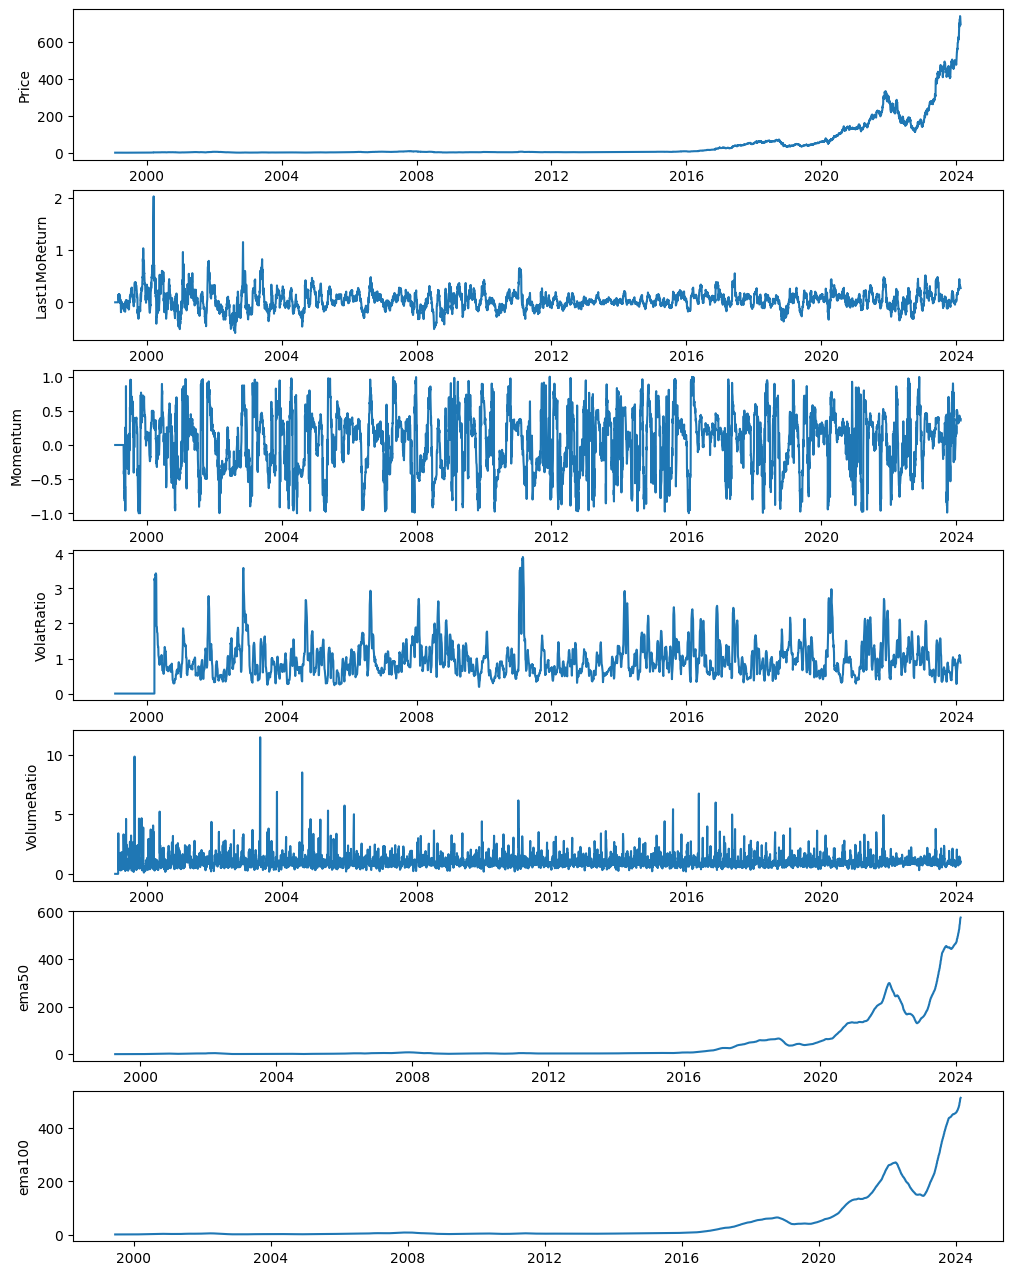

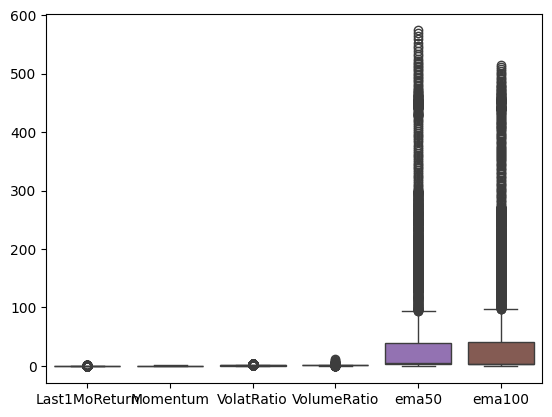

In [145]:
"""

featureCols = [returnCol, momentumCol, volatilityCol, volumeCol]
returns
momentum
VolatRatio
volumeCol

"""
df = df.set_index(keys=[dateCol])

featureCols = [returnCol, momentumCol, volatilityCol, volumeCol, media_movil_50, media_movil_100]
fig, axs = plt.subplots(nrows=len(featureCols)+1, ncols=1, figsize=(12, 16))
axs[0].plot(df.index.values, df.loc[:, priceCol].values)
axs[0].set_ylabel("Price")
for i, col in enumerate(featureCols):
    axs[i+1].plot(df.index.values, df.loc[:, col].values)
    axs[i+1].set_ylabel(col)
plt.show()

boxplot = df[featureCols]
sns.boxplot(data=boxplot)
plt.show()

# 7 Construcción del modelo

Construiremos un modelo de red neuronal recurrente (RNN) utilizando la biblioteca TensorFlow y Keras para llevar a cabo tareas de regresión.

El modelo consiste en una capa LSTM seguida de capas densas para procesar las características de entrada y predecir una salida continua.

Además, se define una función para crear o cargar un punto de control del modelo, lo que permite guardar y restaurar el modelo en caso de interrupciones o reinicios.

Finalmente, el modelo se compila con una función de pérdida y un optimizador específicos antes de ser utilizado para entrenar y realizar predicciones.

In [149]:
# Creamos un modelo secuencial de Keras
nnet = tf.keras.Sequential()

# Agregamos una capa LSTM al modelo con el número de unidades especificado y la forma de entrada
nnet.add(tf.keras.layers.LSTM(nUnit, input_shape=(None, 5)))  # Modificamos input_shape

# Agregamos una capa densa con activación ReLU
nnet.add(tf.keras.layers.Dense(5, activation="relu"))
nnet.add(tf.keras.layers.Dense(5, activation="relu"))
nnet.add(tf.keras.layers.Dense(5, activation="relu"))

# Agregamos una capa de salida densa
nnet.add(tf.keras.layers.Dense(1))

# Definimos la función de pérdida y el optimizador
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compilamos el modelo con la función de pérdida y el optimizador definidos
nnet.compile(optimizer=optimizer, loss=loss)

# Función para crear un punto de control del modelo
# Esta función garantiza que el modelo esté disponible y listo para ser utilizado,
# ya sea creándolo desde cero o cargándolo desde un punto de control existente.


# 8 Entrenamiento del modelo

In [150]:
##
# nnet.fit(): realiza el entrenamiento del modelo.
## datos de entrada los datos de entrada (rnnTrainData[0])
## datos de salida esperados (rnnTrainData[1]).

#batch_size=batchSize: Especifica el tamaño del lote utilizado durante el entrenamiento.
#epochs=nEpoch: Indica cuántas veces se iterará sobre todo el conjunto de datos de entrenamiento.
# history: Esta variable guarda el historial del entrenamiento, incluyendo la pérdida (error) del modelo en cada época.

history = nnet.fit(rnnTrainData[0], rnnTrainData[1], batch_size=batchSize, epochs=nEpoch)


Epoch 1/100
475/475 [==============================] - 6s 6ms/step - loss: 0.0286
Epoch 2/100
475/475 [==============================] - 3s 6ms/step - loss: 0.0278
Epoch 3/100
475/475 [==============================] - 4s 8ms/step - loss: 0.0262
Epoch 4/100
475/475 [==============================] - 3s 7ms/step - loss: 0.0255
Epoch 5/100
475/475 [==============================] - 3s 6ms/step - loss: 0.0248
Epoch 6/100
475/475 [==============================] - 3s 6ms/step - loss: 0.0246
Epoch 7/100
475/475 [==============================] - 3s 7ms/step - loss: 0.0243
Epoch 8/100
475/475 [==============================] - 4s 8ms/step - loss: 0.0243
Epoch 9/100
475/475 [==============================] - 3s 6ms/step - loss: 0.0240
Epoch 10/100
475/475 [==============================] - 3s 6ms/step - loss: 0.0240
Epoch 11/100
475/475 [==============================] - 3s 6ms/step - loss: 0.0239
Epoch 12/100
475/475 [==============================] - 4s 8ms/step - loss: 0.0238
Epoch 13/100


````

* rnnTrainData[0] : secuencias de características que se utilizarán como entrada al modelo.

Cada muestra de entrenamiento en rnnTrainData[0] consiste en una secuencia de características en el tiempo, donde cada paso de tiempo representa un conjunto de características en un momento específico.

* rnnTrainData[1] : contiene las etiquetas correspondientes a las secuencias de características en rnnTrainData[0].
Estas etiquetas representan los valores de salida esperados para el modelo después de procesar las secuencias de características de entrada.

Por lo tanto, durante el entrenamiento, el modelo utilizará las secuencias de características en rnnTrainData[0] para generar predicciones, y luego comparará esas predicciones con las etiquetas en rnnTrainData[1] para calcular la pérdida (error) y ajustar sus pesos y sesgos en consecuencia.

````


# 9 Visualización del historial de convergencia


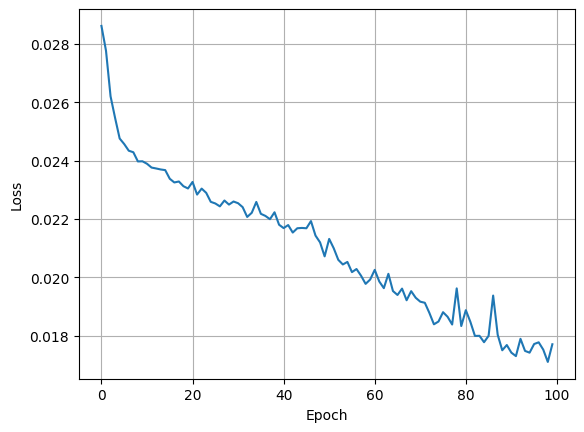

In [151]:
plt.plot(history.epoch, history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 10 Evaluación del modelo

149/149 [==============================] - 1s 2ms/step


<ipython-input-152-acb185a3bea6>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pxPred[i] = px*(1.0 + predict[i])


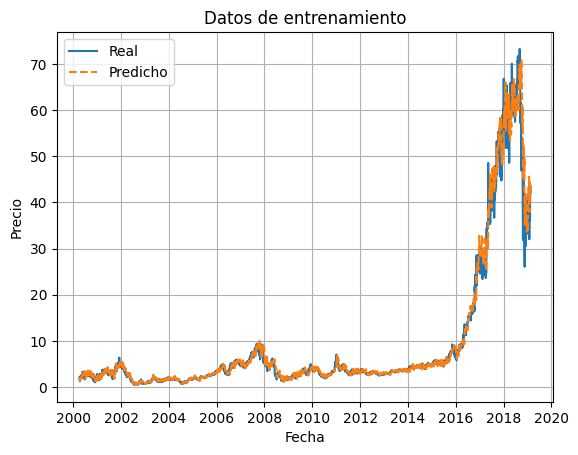

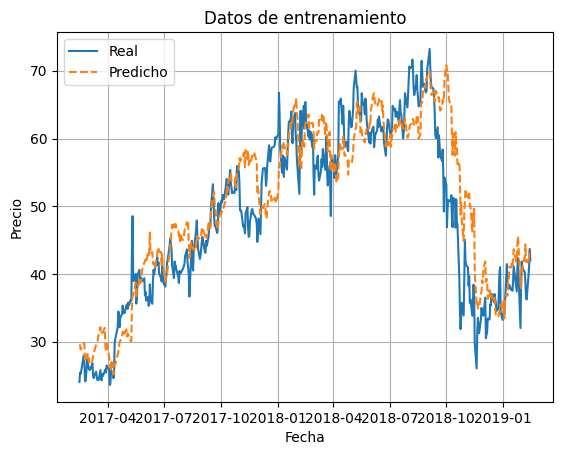

40/40 [==============================] - 0s 3ms/step


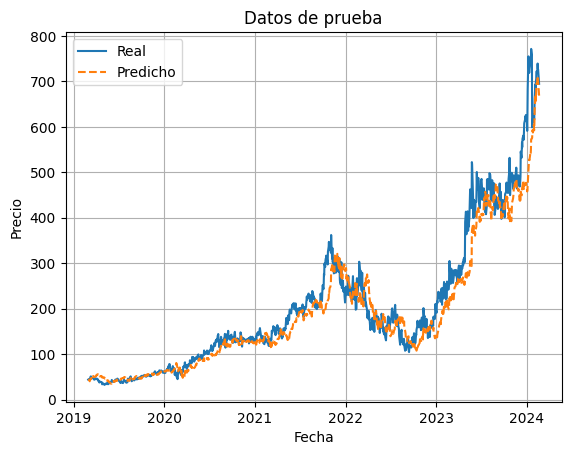

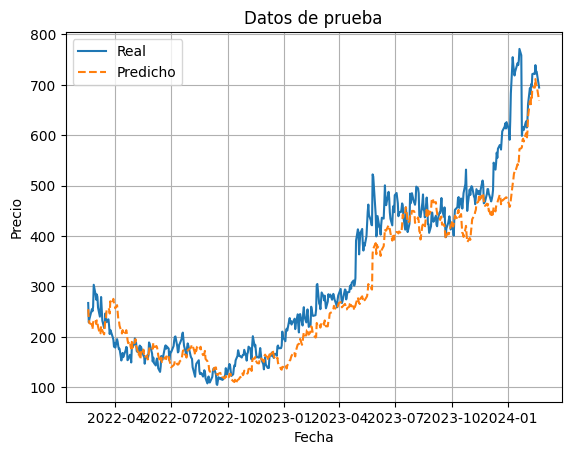

In [152]:
# Calculamos el error cuadrático medio para evaluar el rendimiento del modelo
mse = tf.keras.losses.MeanSquaredError()
# Contador para distinguir entre los datos de train y test
cnt = 0
# Iteramos sobre los conjuntos de datos de entrenamiento y prueba
for X, y in [rnnTrainData, rnnTestData]:
    # Realizamos la predicción utilizando el modelo entrenado
    predict = nnet.predict(X)
    # Calculamos el error cuadrático medio entre los valores reales y las predicciones
    loss = mse(y[:, -1], predict[:, 0]).numpy()
    logging.info("Error final = %f", loss)
    # Calculamos el error cuadrático medio para una predicción de línea base
    loss = mse(y[:, -1], X[:, -1, 0]).numpy()
    logging.info("Error de línea base = %f", loss)
    # Generamos gráficas de los precios reales vs. predichos para los datos de entrenamiento y prueba
    pxActual = np.zeros(y.shape[0], dtype=np.float32)
    pxPred = np.zeros(y.shape[0], dtype=np.float32)
    dts = [None] * y.shape[0]
    # Seleccionamos el dataframe adecuado según el contador
    df = trainDf if cnt == 0 else testDf
    # Iteramos sobre los datos para generar las gráficas
    for i in range(pxActual.shape[0]):
        px = df.loc[i+nTimestep, priceCol]
        pxActual[i] = px*(1.0 + y[i, -1])
        pxPred[i] = px*(1.0 + predict[i])
        dts[i] = df.loc[i+nTimestep, dateCol]
    # Mostramos la gráfica de precios reales vs. predichos para todas las fechas
    plt.plot(dts, pxActual, label="Real")
    plt.plot(dts, pxPred, "--", label="Predicho")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.grid(True)
    titulo = "Datos de entrenamiento" if cnt == 0 else "Datos de prueba"
    plt.title(titulo)
    plt.legend()
    plt.show()
    # Mostramos la gráfica de precios reales vs. predichos para las últimas 504 fechas (últimos 2 años) #####
    plt.plot(dts[-252*2:], pxActual[-252*2:], label="Real")
    plt.plot(dts[-252*2:], pxPred[-252*2:], "--", label="Predicho")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.grid(True)
    plt.title(titulo)
    plt.legend()
    plt.show()
    cnt += 1